In [1]:
import os
import sys
import h5py
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14

from src.dataset import StructuresDataset, collate_batch_features, select_by_sid, select_by_interface_types
from src.data_encoding import encode_structure, encode_features, extract_topology, categ_to_resnames, resname_to_categ
from src.structure import data_to_structure, encode_bfactor
from src.structure_io import save_pdb, read_pdb
from src.scoring import bc_scoring, bc_score_names

In [2]:
def read_bfactor(pdb_filepath):
    bfactors = []
    with open(pdb_filepath, 'r') as fs:
        for line in fs:
            if (line[:4] == 'ATOM') and (line[13:15] == "CA"):
                bfactors.append(float(line[60:66]))
    
    return np.array(bfactors)

In [3]:
# model parameters
# R3
#save_path = "model/save/i_v3_0_2021-05-27_14-27"  # 89
#save_path = "model/save/i_v3_1_2021-05-28_12-40"  # 90
# R4
#save_path = "model/save/i_v4_0_2021-09-07_11-20"  # 89
save_path = "model/save/i_v4_1_2021-09-07_11-21"  # 92

# select saved model
model_filepath = os.path.join(save_path, 'model_ckpt.pt')
#model_filepath = os.path.join(save_path, 'model.pt')

# data parameters
benchmark_list_filepath = "data/masif-site/benchmark_pdbs.txt"
data_path = "data/masif-site/01-benchmark_pdbs"

In [4]:
# add module to path
if save_path not in sys.path:
    sys.path.insert(0, save_path)
    
# load functions
from config import config_model, config_data
from data_handler import Dataset
from model import Model

In [5]:
# define device
device = pt.device("cuda")

# create model
model = Model(config_model)

# reload model
model.load_state_dict(pt.load(model_filepath, map_location=pt.device("cpu")))

# set model to inference
model = model.eval().to(device)

In [6]:
# load benchmark list
#bids = [bid.strip() for bid in open(benchmark_list_filepath, 'r')]
bench_pred_dict = json.load(open("masif-site_benchmark/masif_pred_per_res.json", 'r'))
bids = list(bench_pred_dict)

# set up dataset
dataset = Dataset("datasets/contacts_rr5A_64nn_8192.h5")

# filter dataset
m = select_by_sid(dataset, bids) # select by sids
m &= select_by_interface_types(dataset, config_data['l_types'], np.concatenate(config_data['r_types']))  # select by interface type

# update dataset selection
dataset.update_mask(m)

# set dataset types
dataset.set_types(config_data['l_types'], config_data['r_types'])

# debug print
print(len(dataset))

53


In [7]:
aucs = np.zeros(len(dataset))
aucs_bench = []
with pt.no_grad():
    for i in range(len(dataset)):
        # get data
        X, ids_topk, q, M, y = dataset[i]

        # pack data and setup sink (IMPORTANT)
        X, ids_topk, q, M = collate_batch_features([[X, ids_topk, q, M]])

        # run model
        z = model(X.to(device), ids_topk.to(device), q.to(device), M.float().to(device))

        # prediction
        p = pt.sigmoid(z)

        # scoring
        scores = bc_scoring(y.to(device), p)[:,0]
        
        # store auc
        aucs[i] = scores[6].cpu().numpy()
        
        # debug print
        print(', '.join([dataset.ukeys[i]]+[f'{bc_score_names[i]}={scores[i]:.3f}' for i in range(scores.shape[0])]))
        
        if False:
            # data to structure
            structure = data_to_structure(X.numpy(), q.numpy(), M.numpy(), dataset.std_elements, dataset.std_resnames, dataset.std_names)

            # encode bfactor
            structure = encode_bfactor(structure, p[:,0].cpu().numpy())

            # save pdb
            cid = dataset.ukeys[i].split('/')[-1][0]
            filepath = "pdbs_test/"+dataset.ukeys[i].replace('/','_')+".pdb"
            save_pdb({cid:structure}, filepath)

            # encode bfactor and save groundtruth
            structure = encode_bfactor(structure, y[:,0].cpu().numpy())
            filepath = "pdbs_test/"+dataset.ukeys[i].replace('/','_')+"_T.pdb"
            save_pdb({cid:structure}, filepath)
        
        # get bid
        key = dataset.ukeys[i]
        bid = key.split('/')[1]+'_'+key.split('/')[3][0]
        
        if y.shape[0] == len(bench_pred_dict[bid]):
            # benchmark masif
            p_b0 = pt.from_numpy(np.array(bench_pred_dict[bid])).unsqueeze(1).float()
            scores_b0 = bc_scoring(y[:,:1], p_b0)[:,0]
            
            if False:
                # encode bfactor and save groundtruth
                structure = encode_bfactor(structure, p_b0.cpu().numpy())
                filepath = "pdbs_test/"+dataset.ukeys[i].replace('/','_')+"_M.pdb"
                save_pdb({cid:structure}, filepath)
            
            # benchmark sppider
            pdb_fp_sppider = "masif-site_benchmark/sppider_pred/{}.pdb".format(bid)
            p_b1 = pt.from_numpy(read_bfactor(pdb_fp_sppider)).unsqueeze(1).float()
            scores_b1 = bc_scoring(y[:,:1], p_b1)[:,0]
            
            # benchmark psiver
            pdb_fp_psiver = "masif-site_benchmark/psiver_pred/psiver_pdbs/{}.pdb".format(bid)
            p_b2 = pt.from_numpy(read_bfactor(pdb_fp_psiver)).unsqueeze(1).float()
            scores_b2 = bc_scoring(y[:,:1], p_b2)[:,0]
            
            # store results
            aucs_bench.append({
                'sid':bid,
                'PeSTo': float(scores[6].cpu().numpy()),
                'MaSIF-site':float(scores_b0[6].cpu().numpy()),
                'SPPIDER':float(scores_b1[6].cpu().numpy()),
                'PSIVER':float(scores_b2[6].cpu().numpy())
            })

W1/1W1W/5/B:0, acc=0.887, ppv=0.743, npv=0.904, tpr=0.481, tnr=0.967, mcc=0.539, auc=0.933, std=0.262
V9/2V9T/1/B:0, acc=0.890, ppv=nan, npv=0.890, tpr=0.000, tnr=1.000, mcc=nan, auc=0.948, std=0.055
I2/1I2M/1/B:0, acc=0.907, ppv=1.000, npv=0.906, tpr=0.100, tnr=1.000, mcc=0.301, auc=0.962, std=0.094
V3/2V3B/1/A:0, acc=0.948, ppv=0.000, npv=0.953, tpr=0.000, tnr=0.994, mcc=-0.016, auc=0.656, std=0.074
XL/4XL5/1/C:0, acc=0.845, ppv=0.346, npv=0.979, tpr=0.818, tnr=0.848, mcc=0.465, auc=0.949, std=0.325
F4/2F4M/2/A:0, acc=0.902, ppv=0.741, npv=0.918, tpr=0.476, tnr=0.972, mcc=0.544, auc=0.911, std=0.235
F4/2F4M/2/A:1, acc=0.902, ppv=0.741, npv=0.918, tpr=0.476, tnr=0.972, mcc=0.544, auc=0.911, std=0.235
YC/4YC7/1/B:0, acc=0.859, ppv=0.524, npv=0.952, tpr=0.750, tnr=0.879, mcc=0.547, auc=0.925, std=0.332
BH/3BH6/1/B:0, acc=0.930, ppv=0.818, npv=0.938, tpr=0.500, tnr=0.986, mcc=0.606, auc=0.977, std=0.187
RT/3RT0/1/A:0, acc=0.939, ppv=0.684, npv=0.955, tpr=0.481, tnr=0.980, mcc=0.543, auc=

In [8]:
# pack benchmark results
df = pd.DataFrame(aucs_bench)

# print summary
for i in range(4):
    print(f"[{df.columns.values[i+1]}] mean={df.mean().values[i]:.2f}, median={df.median().values[i]:.2f}")

[PeSTo] mean=0.86, median=0.92
[MaSIF-site] mean=0.79, median=0.80
[SPPIDER] mean=0.72, median=0.73
[PSIVER] mean=0.63, median=0.64


/tmp/ipykernel_3271/3041392956.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(f"[{df.columns.values[i+1]}] mean={df.mean().values[i]:.2f}, median={df.median().values[i]:.2f}")


/tmp/ipykernel_3271/1667019041.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  summary_dict = df.median().to_dict()


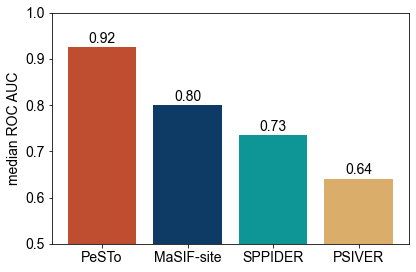

In [9]:
#from theme import colors
colors = ['#bf4e30', '#0d3b66', '#0e9595', '#dbad6a']

# extract median auc for all methods
summary_dict = df.median().to_dict()
med_aucs, aucs = [], []
methods = list(summary_dict)
for method in methods:
    med_aucs.append(summary_dict[method])
    aucs.append(df[method].values)

# plot
plt.figure()
plt.bar(np.arange(len(med_aucs)), med_aucs, color=colors)
for i in range(len(med_aucs)):
    plt.text(i, med_aucs[i]+1e-2, "{:.2f}".format(med_aucs[i]), size=14, ha="center")
plt.xticks(np.arange(len(methods)), methods)
plt.ylabel("median ROC AUC")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig("results/interface_ppi_benchmark_roc_auc.svg")
plt.savefig("results/interface_ppi_benchmark_roc_auc.png", dpi=300)
plt.show()

In [10]:
# round values
df = df.round(3)

# get best method
ids_max = np.argmax(df.values[:,1:5].astype(np.float32), 1)
df["best"] = df.columns.values[1:][ids_max]

# get delta between methods
#df['delta'] = df["PeSTo"] - df["MaSIF-site"]

# sort
#df = df.sort_values('delta', ascending=False)
df = df.sort_values('PeSTo', ascending=False)

# save dataframe
df.to_csv("results/interface_ppi_detailed_benchmark.csv", index=False)

# display
display(df)

,sid,PeSTo,MaSIF-site,SPPIDER,PSIVER,best
11,3H6G_B,0.996,0.947,0.848,0.525,PeSTo
26,4ETP_A,0.995,0.947,0.904,0.434,PeSTo
27,4ETP_B,0.993,0.932,0.933,0.480,PeSTo
32,1JTD_B,0.988,0.972,0.816,0.958,PeSTo
44,4M0W_A,0.986,0.842,0.714,0.635,PeSTo
35,1W1W_B,0.986,0.940,0.770,0.513,PeSTo
43,2F4M_A,0.982,0.932,0.806,0.529,PeSTo
19,3WN7_A,0.982,0.677,0.471,0.724,PeSTo
16,4DVG_B,0.980,0.732,0.664,0.605,PeSTo
47,3VYR_B,0.978,0.888,0.861,0.655,PeSTo


In [14]:
np.bincount(ids_max)

array([38, 10,  3,  2])

In [11]:
# display
#display(df.sort_values('delta', ascending=True))

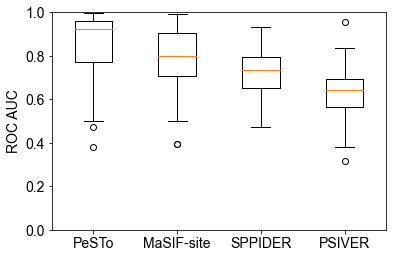

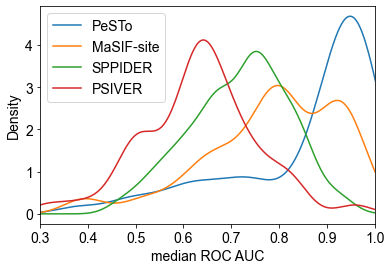

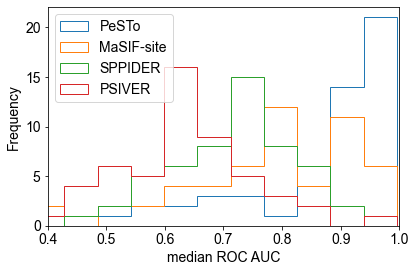

In [12]:
# other plots
plt.figure()
plt.boxplot(aucs)
plt.xticks(np.arange(len(methods))+1, methods)
plt.ylabel("ROC AUC")
plt.ylim(0.0, 1.0)
plt.show()

df.plot.kde(bw_method=0.3)
plt.xlim(0.3, 1.0)
plt.xlabel("median ROC AUC")
plt.legend(loc='upper left')
plt.show()

df.plot.hist(bins=12, histtype='step')
plt.xlim(0.4, 1.0)
plt.xlabel("median ROC AUC")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()